In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
from numpy.random import multivariate_normal as mvn
from scipy.optimize import minimize

In [575]:
class QuasiPeriodicKernel:
    def __init__(self, amplitude, P, length_scale_periodic, length_scale_exp):
        self.amplitude = amplitude
        self.length_scale_exp = length_scale_exp
        self.length_scale_periodic = length_scale_periodic
        self.P = P
        
        self.kernel = None
        self.loglikelihood = None
        self.x1 = None
        self.x2 = None
        self.y = None
        
    def compute_kernel(self, x1, x2, y_err=None, jitter=1e-10):
        self.x1 = x1
        self.x2 = x2
        
        tau = np.subtract.outer(x1, x2)  # pairwise differences
        
        self.kernel = (self.amplitude**2) * np.exp(
            -(
                ((tau/self.length_scale_exp)**2)/2 +
                (np.sin(np.pi*tau/self.P)**2) / (self.length_scale_periodic**2)
            )
        )
        
        if y_err is not None:
            self.kernel += np.diag(y_err)
        
        np.fill_diagonal(self.kernel, self.kernel.diagonal() + jitter)
        
        return self
    
    def compute_loglikelihood(self, y):
        self.y = y
        
        factor, flag = spl.cho_factor(self.kernel)
        lodget = 2*np.sum(np.log(np.diag(factor)))
        gof = np.dot(y, spl.cho_solve((factor, flag), y))
        self.loglikelihood = -0.5*(gof + lodget + len(y)*np.log(2*np.pi))
        
        return self
    
    def clone(self):
        return QuasiPeriodicKernel(self.amplitude, self.P, self.length_scale_periodic, self.length_scale_exp)
    
    def compute_posterior(self, x_test):
        assert self.kernel is not None, "Kernel has not been computed. Please run compute_kernel first."
        assert self.loglikelihood is not None, "Loglikelihood has not been computed. Please run compute_loglikelihood first."
        
        temp_kernel = self.clone()
        
        K_test_train = temp_kernel.compute_kernel(x_test, self.x1).kernel  # Kernel between test and train points
        K_test_test = temp_kernel.compute_kernel(x_test, x_test).kernel  # Kernel for the test points
        
        factor, flag = spl.cho_factor(self.kernel)  # Cholesky decomposition of the training kernel matrix
        K_inv_y = spl.cho_solve((factor, flag), self.y)  # Solve self.kernel^-1 * y_train
        
        mu_post = np.dot(K_test_train, K_inv_y)  # Compute the posterior mean
        
        v = spl.cho_solve((factor, flag), K_test_train.T)  # Solve self.kernel^-1 * K_test_train.T
        cov_post = K_test_test - np.dot(K_test_train, v)  # Compute the posterior covariance
        
        return mu_post, cov_post
    
    def fit(self, x, y, y_err, bounds=None, jitter=1e-10):
        self.compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y)
        
        if bounds is None:
            bounds = [[(1e-4, None), (1e-4, None), (1e-4, None), (1e-4, None)]]
        
        def objective(theta):
            return -QuasiPeriodicKernel(*theta).compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y).loglikelihood
        
        result = minimize(
            objective, 
            np.array([self.amplitude, self.P, self.length_scale_periodic, self.length_scale_exp]), 
            method='L-BFGS-B', 
            # bounds=bounds
        )
        
        return result
        


class StellarActivityGP:
    def __init__(self, x, y, y_err=None):
        self. x = x
        self.y = y if len(y.shape) > 1 else y.reshape(-1, 1)
        
        if y_err is None:
            y_err = np.zeros_like(y)
        
        self.y_err = y_err if len(y_err.shape) > 1 else y_err.reshape(-1, 1)
        
        self.y_dim = y.shape[1] if len(y.shape) > 1 else 1
        
    def fit(self, amplitudes: list, P, length_scale_periodic, length_scale_exp, bounds=None, jitter=1e-10):
        assert len(amplitudes) == self.y_dim, "Number of amplitudes must match the number of dimensions in y"
        
        if bounds is None:
            bounds = [(1e-4, None) for _ in range(self.y_dim)] + [(1e-4, None), (1e-4, None), (1e-4, None)]
        
        def objective(theta):
            loglikelihood = 0
            
            amplitudes = theta[:-3]
            P = theta[-3]
            length_scale_periodic = theta[-2]
            length_scale_exp = theta[-1]
            
            kernels = [
                QuasiPeriodicKernel(amplitude, P, length_scale_periodic, length_scale_exp)
                for amplitude in amplitudes
            ]
            
            for i, kernel in enumerate(kernels):
                loglikelihood += (
                    kernel.compute_kernel(self.x, self.x, self.y_err[:, i], jitter).compute_loglikelihood(self.y[:, i]).loglikelihood
                )
            
            return -loglikelihood
        
        result = minimize(
            objective, 
            np.array([*amplitudes, P, length_scale_periodic, length_scale_exp]), 
            method='L-BFGS-B', 
            bounds=bounds
        )
        
        return result
    

In [595]:
class PeriodicKernel:
    def __init__(self, amplitude, P, length_scale_periodic):
        self.amplitude = amplitude
        self.length_scale_periodic = length_scale_periodic
        self.P = P
        
        self.kernel = None
        self.loglikelihood = None
        self.x1 = None
        self.x2 = None
        self.y = None
        
    def compute_kernel(self, x1, x2, y_err=None, jitter=1e-10):
        self.x1 = x1
        self.x2 = x2
        
        tau = np.subtract.outer(x1, x2)  # pairwise differences
        
        self.kernel = (self.amplitude**2) * np.exp(
            -2*(
                (np.sin(np.pi*tau/self.P)**2) / (self.length_scale_periodic**2)
            )
        )
        
        if y_err is not None:
            self.kernel += np.diag(y_err)
        
        np.fill_diagonal(self.kernel, self.kernel.diagonal() + jitter)
        
        return self
    
    def compute_loglikelihood(self, y):
        self.y = y
        
        factor, flag = spl.cho_factor(self.kernel)
        lodget = 2*np.sum(np.log(np.diag(factor)))
        gof = np.dot(y, spl.cho_solve((factor, flag), y))
        self.loglikelihood = -0.5*(gof + lodget + len(y)*np.log(2*np.pi))
        
        return self
    
    def clone(self):
        return PeriodicKernel(self.amplitude, self.P, self.length_scale_periodic)
    
    def compute_posterior(self, x_test):
        assert self.kernel is not None, "Kernel has not been computed. Please run compute_kernel first."
        assert self.loglikelihood is not None, "Loglikelihood has not been computed. Please run compute_loglikelihood first."
        
        temp_kernel = self.clone()
        
        K_test_train = temp_kernel.compute_kernel(x_test, self.x1).kernel  # Kernel between test and train points
        K_test_test = temp_kernel.compute_kernel(x_test, x_test).kernel  # Kernel for the test points
        
        factor, flag = spl.cho_factor(self.kernel)  # Cholesky decomposition of the training kernel matrix
        K_inv_y = spl.cho_solve((factor, flag), self.y)  # Solve self.kernel^-1 * y_train
        
        mu_post = np.dot(K_test_train, K_inv_y)  # Compute the posterior mean
        
        v = spl.cho_solve((factor, flag), K_test_train.T)  # Solve self.kernel^-1 * K_test_train.T
        cov_post = K_test_test - np.dot(K_test_train, v)  # Compute the posterior covariance
        
        return mu_post, cov_post
    
    def fit(self, x, y, y_err, bounds=None, jitter=1e-10):
        self.compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y)
        
        if bounds is None:
            bounds = [[(1e-4, None), (1e-4, None), (1e-4, None)]]
        
        def objective(theta):
            return -PeriodicKernel(*theta).compute_kernel(x, x, y_err, jitter).compute_loglikelihood(y).loglikelihood
        
        result = minimize(
            objective, 
            np.array([self.amplitude, self.P, self.length_scale_periodic]), 
            method='L-BFGS-B', 
            # bounds=bounds
        )
        
        return result

[ 1.43265237 12.54801856  1.21163939]


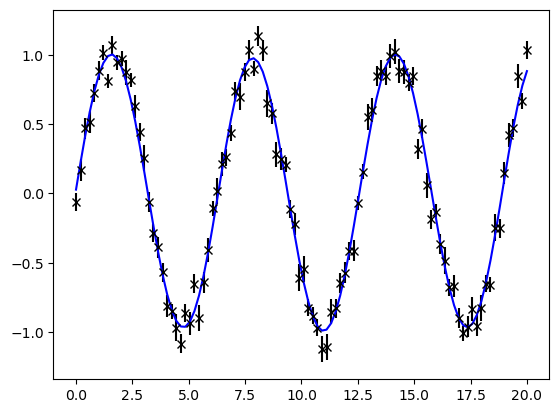

In [617]:
def objective(theta):
    return -PeriodicKernel(*theta).compute_kernel(x, x, y_err).compute_loglikelihood(y).loglikelihood

result = minimize(
    objective, 
    np.array([10, 10, 1]), 
    method='L-BFGS-B', 
    # bounds=bounds
)

x = np.linspace(0, 20, 100)
y = np.sin(x) + np.random.normal(0, 0.1, x.shape)
y_err = np.random.uniform(0.05, 0.1, x.shape)
plt.errorbar(x, y, yerr=y_err, fmt='kx')

gp = PeriodicKernel(*result.x)
result = gp.fit(x, y, y_err)
y_pred, y_pred_err = gp.compute_posterior(x)
plt.plot(x, y_pred, 'b')

print(result.x)

# Now lets implement it onto our own data

In [460]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

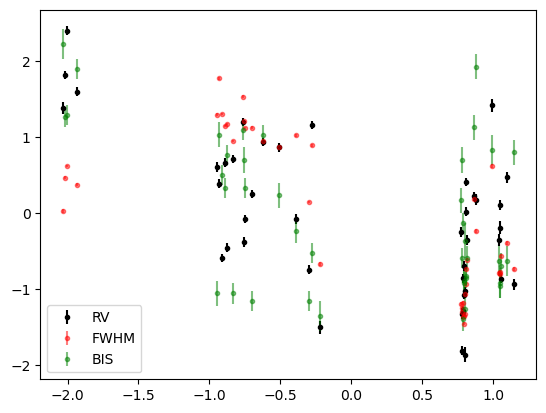

In [536]:
data = pd.read_csv(
    '../../data/ex2_RVs.txt',
    sep=',',
    header=None,
    names=['time', 'radial_velocity', 'radial_velocity_uncertainty', 'FWHM_CCF',
           'FWHM_CCF_uncertainty', 'BIS', 'BIS_uncertainty', 'instrument'],
    skiprows=8,
)

data = data[~data['instrument'].isin(['INST1'])]

time_scaler = StandardScaler()
rv_scaler = StandardScaler()
fwhm_scaler = StandardScaler()
bis_scaler = StandardScaler()
y_scalers = [rv_scaler, fwhm_scaler, bis_scaler]

time = data['time'].values
rv = data['radial_velocity'].values
rv_err = data['radial_velocity_uncertainty'].values
fwhm = data['FWHM_CCF'].values
fwhm_err = data['FWHM_CCF_uncertainty'].values
bis = data['BIS'].values
bis_err = data['BIS_uncertainty'].values

time = time_scaler.fit_transform(time.reshape(-1, 1)).ravel()
rv = rv_scaler.fit_transform(rv.reshape(-1, 1)).ravel()
rv_err = (rv_err / rv_scaler.scale_).ravel()
fwhm = fwhm_scaler.fit_transform(fwhm.reshape(-1, 1)).ravel()
fwhm_err = (fwhm_err / fwhm_scaler.scale_).ravel()
bis = bis_scaler.fit_transform(bis.reshape(-1, 1)).ravel()
bis_err = (bis_err / bis_scaler.scale_).ravel()


y = np.vstack([rv, fwhm, bis]).T
y_err = np.vstack([rv_err, fwhm_err, bis_err]).T

plt.errorbar(time, y[:, 0], yerr=y_err[:, 0], fmt='k.', label='RV')
plt.errorbar(time, y[:, 1], yerr=y_err[:, 1], fmt='r.', label='FWHM', alpha=0.5)
plt.errorbar(time, y[:, 2], yerr=y_err[:, 2], fmt='g.', label='BIS', alpha=0.5)
plt.legend()

In [537]:
p_lower, p_upper = [21, 41] / time_scaler.scale_
p_lower, p_upper

(0.07454656358118683, 0.14554329080136474)

In [538]:
gp = StellarActivityGP(time, y, y_err)
result = gp.fit(
    [1.0, 1.0, 1.0], 1.0, 1.0, 1.0, 
    bounds=[(1e-4, None), (1e-4, None), (1e-4, None), (p_lower, p_upper), (1e-4, None), (1e-4, None)]
)
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 115.88091724891646
        x: [ 1.408e+00  6.875e-01  1.011e+00  1.221e-01  6.529e-01
             5.061e-01]
      nit: 54
      jac: [-4.724e-03  2.760e-03 -4.022e-04  1.236e+00  3.872e-03
            -4.624e-03]
     nfev: 511
     njev: 73
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [539]:
(result.x[3] * time_scaler.scale_)

array([34.38899326])

-65.59250833032391
-8.988947091643784
-41.299461826948765


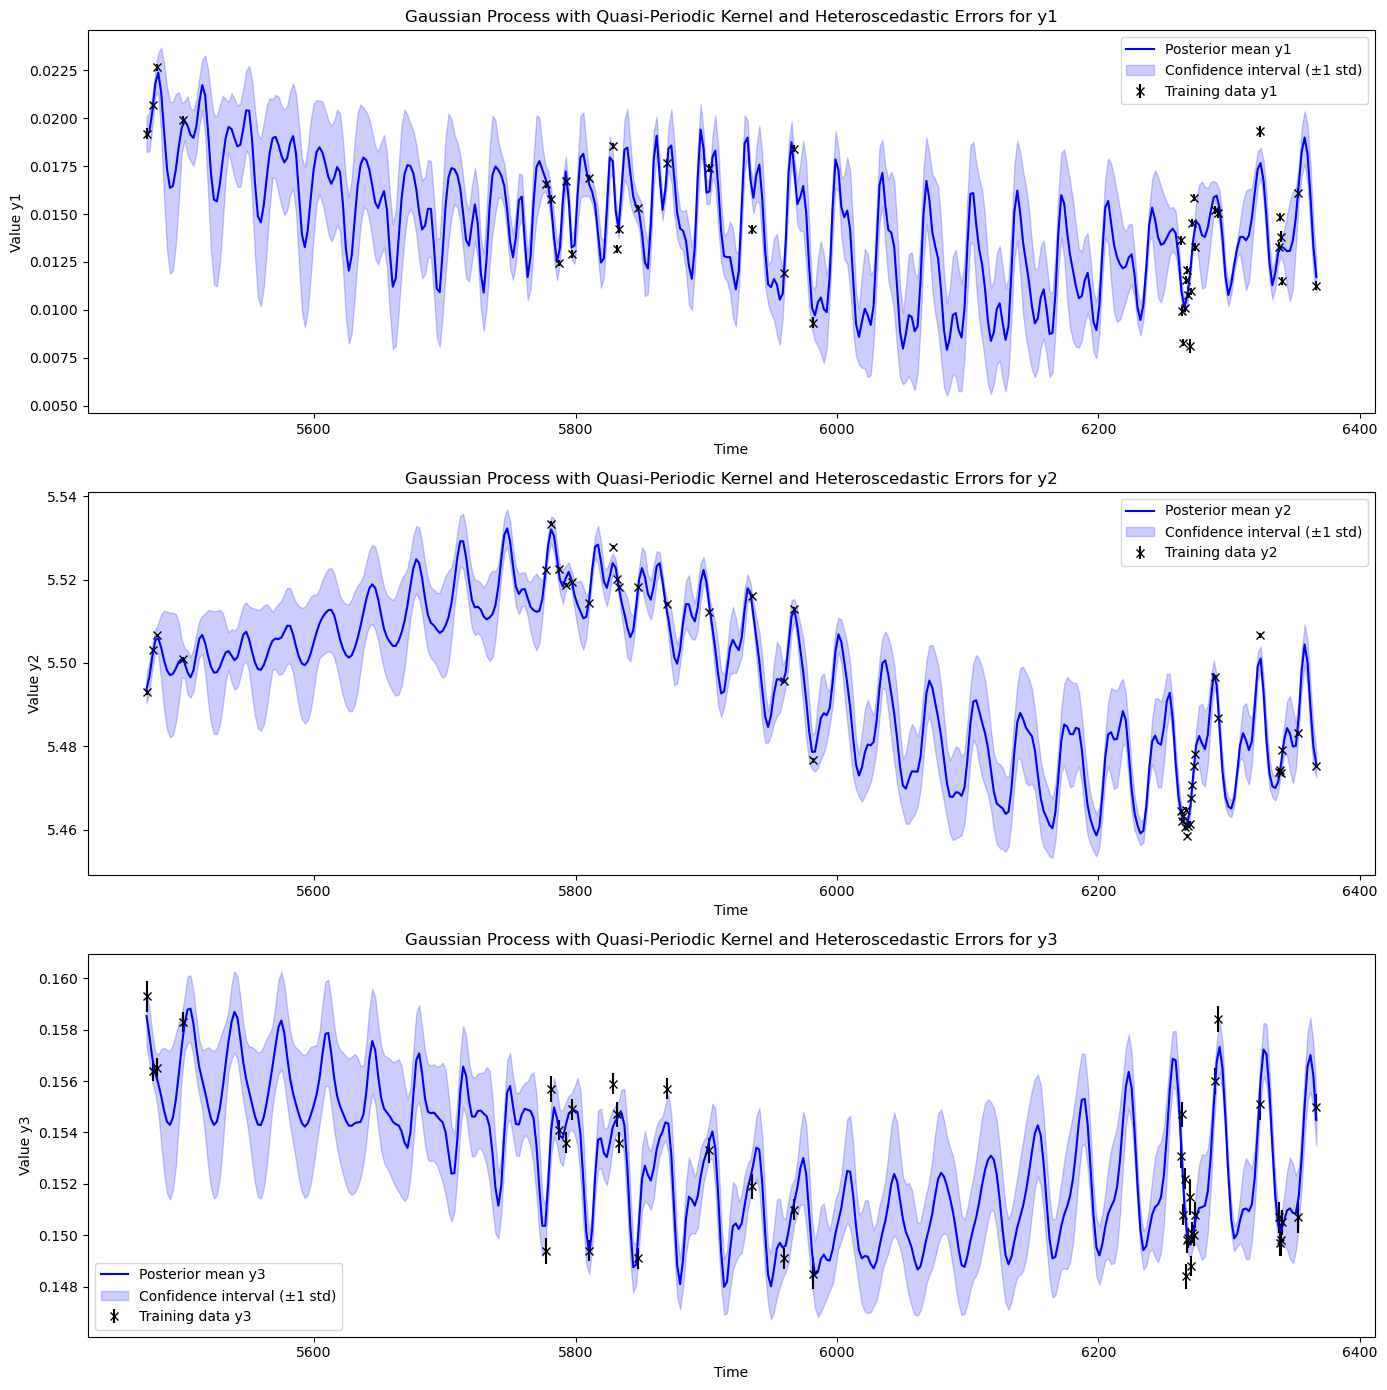

In [540]:
# Extract the optimized parameters
optimized_theta = result.x
optimized_amplitudes = optimized_theta[:-3]
optimized_P = optimized_theta[-3]
optimized_length_scale_periodic = optimized_theta[-2]
optimized_length_scale_exp = optimized_theta[-1]

kernels = [
    QuasiPeriodicKernel(amp, optimized_P, optimized_length_scale_periodic, optimized_length_scale_exp)
    for amp in optimized_amplitudes
]

t_linspace = np.linspace(time.min(), time.max(), 400)

posteriors = []

for i, kernel in enumerate(kernels):
    kernel.compute_kernel(time, time, y_err[:, i]).compute_loglikelihood(y[:, i])
    print(kernel.loglikelihood)
    mu_post, cov_post = kernel.compute_posterior(t_linspace)
    posteriors.append((mu_post, cov_post))

# Plot the results
plt.figure(figsize=(14, 14))

for i, (mu_post, cov_post) in enumerate(posteriors):
    std_post = np.sqrt(np.diag(cov_post))
    plt.subplot(3, 1, i+1)

    plt.errorbar(
        time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform(y[:, i].reshape(-1, 1)).ravel(), 
        yerr=y_err[:, i] * y_scalers[i].scale_, 
        fmt='kx', label=f'Training data y{i+1}'
    )

    plt.plot(
        time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform(mu_post.reshape(-1, 1)), 
        'b', label=f'Posterior mean y{i+1}'
    )

    plt.fill_between(
        time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform((mu_post - 1*std_post).reshape(-1, 1)).ravel(), 
        y_scalers[i].inverse_transform((mu_post + 1*std_post).reshape(-1, 1)).ravel(), 
        color='blue', alpha=0.2, label='Confidence interval (±1 std)'
    )

    plt.xlabel('Time')
    plt.ylabel(f'Value y{i+1}')
    plt.legend()
    plt.title(f'Gaussian Process with Quasi-Periodic Kernel and Heteroscedastic Errors for y{i+1}')

plt.tight_layout()
plt.show()

In [541]:
# kernels[0].compute_kernel(time, time, rv_err).compute_loglikelihood(rv)
# print(kernels[0].loglikelihood)
mu_post, cov_post = kernels[0].compute_posterior(time)

<ErrorbarContainer object of 3 artists>

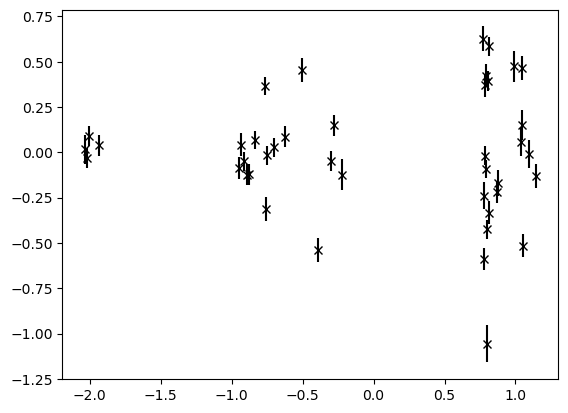

In [542]:
corrected_rv = rv - mu_post
plt.errorbar(time, corrected_rv, rv_err, fmt='kx', label=f'Training data y')
# plt.errorbar(time, rv, fmt='x')

[-7.51956685e-09  1.43074424e+00  1.69212098e+00] -25.454897327037358


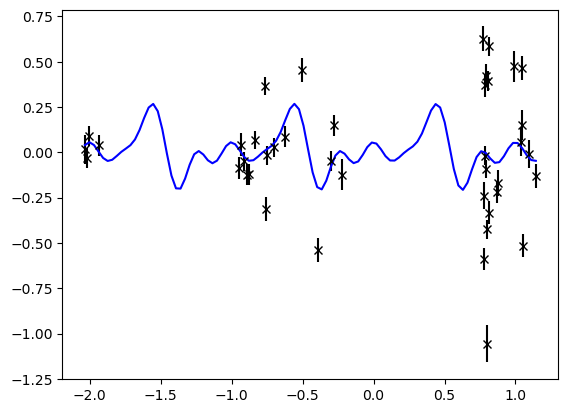

In [629]:
def objective(theta):
    return -PeriodicKernel(*theta).compute_kernel(time, time, rv_err).compute_loglikelihood(corrected_rv).loglikelihood

result = minimize(
    objective, 
    np.array([10, 0.1, 1.2]), 
    method='L-BFGS-B', 
    # bounds=bounds
)

x = np.linspace(time.min(), time.max(), 100)
plt.errorbar(time, corrected_rv, yerr=rv_err, fmt='kx')

gp = PeriodicKernel(1, 1, 1)
result = gp.fit(time, corrected_rv, rv_err)
y_pred, y_pred_err = gp.compute_posterior(x)
plt.plot(x, y_pred, 'b')

print(result.x, gp.loglikelihood)

In [550]:
from scipy.optimize import minimize

# Define the Keplerian equation function for two-dimensional orbits
def keplerian_orbit(t, semi_major_axis, eccentricity, inclination, argument_of_periapsis, longitude_of_ascending_node, true_anomaly):
    # Calculate the position (x, y) in the orbital plane
    # For simplicity, let's assume a simplified model without full Keplerian elements transformation
    M = 2 * np.pi * t / true_anomaly  # Mean anomaly (simplified)
    E = M  # Eccentric anomaly (initial guess for iterative solution)
    
    # Iteratively solve Kepler's equation: E = M + e * sin(E)
    for _ in range(100):
        E = M + eccentricity * np.sin(E)
    
    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))
    
    # Distance from the focal point
    r = semi_major_axis * (1 - eccentricity * np.cos(E))
    
    # Position in orbital plane
    x_orbital = r * np.cos(nu)
    y_orbital = r * np.sin(nu)
    
    # Inclination and other transformations could be applied here for 3D orbits
    
    return x_orbital, y_orbital

# Define the cost function
def cost_function(params, t, y, y_errors):
    semi_major_axis, eccentricity, inclination, argument_of_periapsis, longitude_of_ascending_node, true_anomaly = params
    x_pred, y_pred = keplerian_orbit(t, semi_major_axis, eccentricity, inclination, argument_of_periapsis, longitude_of_ascending_node, true_anomaly)
    # Weighted sum of squared residuals only considering y-errors
    cost = np.sum(((y - y_pred) / y_errors) ** 2)
    return cost

In [552]:
# Initial guess for the parameters
initial_guess = [1, 0.1, 0, 0, 0, 10]

# Use scipy.optimize.minimize to find the optimal parameters
result = minimize(cost_function, initial_guess, args=(time, corrected_rv, rv_err))

# Extract the optimal parameters
optimal_params = result.x

print(f"Optimal Parameters: {optimal_params}")

Optimal Parameters: [-21489.36429503  33119.97837944      0.              0.
      0.          -4382.57977339]


/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1247457735.py:15: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))
/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1247457735.py:15: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))
/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1247457735.py:15: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2), np.sqrt(1 - eccentricity) * np.cos(E / 2))


In [555]:
import numpy as np

def keplerian_model(t, K, P, e, omega, tp, gamma):
    """
    Keplerian model for radial velocity.

    Parameters:
    t : array_like
        Time array.
    K : float
        Velocity semi-amplitude.
    P : float
        Orbital period.
    e : float
        Eccentricity.
    omega : float
        Argument of periastron.
    tp : float
        Time of periastron passage.
    gamma : float
        Systemic velocity.

    Returns:
    rv : array_like
        Radial velocity at each time.
    """
    M = 2 * np.pi * (t - tp) / P  # Mean anomaly
    E = M + e * np.sin(M)  # Eccentric anomaly (approximation)
    try:
        nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))  # True anomaly
    except:
        print(e)
    
    rv = gamma + K * (np.cos(nu + omega) + e * np.cos(omega))
    return rv

from scipy.optimize import curve_fit

# Initial guesses for the parameters
initial_guess = [10, 365, 0.1, 0, time[0], 0]  # K, P, e, omega, tp, gamma

# Fit the model to the data
popt, pcov = curve_fit(keplerian_model, time, corrected_rv, sigma=rv_err, p0=initial_guess)

# Extract the fitted parameters
K_fit, P_fit, e_fit, omega_fit, tp_fit, gamma_fit = popt


/var/folders/13/867mc06s1kz32cp88g91g9gc0000gn/T/ipykernel_98234/1021025177.py:30: RuntimeWarning: invalid value encountered in sqrt
  nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))  # True anomaly
